# Notebook Objective - Model Training
This notebook contains the training part including loading and augmentation of the images

In [3]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import seaborn as sns

from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomZoom, Resizing, RandomRotation
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.nn import local_response_normalization

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

### Some Utility Functions
- show_sample_images: plots the first few images of a given tensorflow dataset
- TimingCallback: a Callback for the model training which logs the time per epoch
- apply_data_augmentation: a function to apply chosen layers of transformation to a dataset
- resize_and_rescale_images: applies a rescaling (usually [0, 255] --> [0, 1]) and a resizing (e.g [256 x 256] --> [224 x 224]) to the images
- calculate_class_weights: takes a dataset (images, labels) and calculates the class weight distribution. Also returns a list of the class_names

In [4]:
def show_sample_images(dataset, sample_size=4):
    '''
    This function takes a dataset and shows samples of the images
    '''

    for images, labels in dataset.take(1):
        images = images[:(min(sample_size, len(images)))]
        labels = labels[:(min(sample_size, len(labels)))]

    rows, cols = divmod(len(images), 4)
    rows, cols = rows+1, cols+1
    plt.figure(figsize=(20, 20))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, 4, i+1)
        plt.imshow(image[:, :, 0])
        class_name = dataset.class_names[list(label).index(1)]
        plt.title(class_name, color= 'blue', fontsize= 10)
        plt.axis('off')
    plt.show()

class TimingCallback(Callback):

    def __init__(self):
        self.logs={'time': [], 'epoch': []}
    
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime=time()
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs['time'].append(time()-self.starttime)
        self.logs['epoch'].append(epoch)

def apply_data_augmentation(dataset):
    data_preparation = tf.keras.Sequential([
        RandomRotation(factor = (.10), fill_mode = 'reflect', interpolation = 'bilinear'),
        RandomFlip(mode='horizontal'),
        RandomZoom(0.1),
        ])
    dataset = dataset.map(
        lambda x, y: (data_preparation(x, training=True), y)
        )
    return dataset

def resize_and_rescale_images(dataset, target_size, scale=1./255):
    # target_size is a tuple of length 2 (width, height)
    mods = tf.keras.Sequential([
        Rescaling(scale),
        Resizing(*target_size)
    ])
    dataset = dataset.map(lambda x, y: (mods(x, training=True), y))
    return dataset

def calculate_class_weights(dataset):
    labels = np.concatenate([tf.argmax(y, axis=1) for _, y in dataset], axis=0)
    class_names = dataset.class_names
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
    return class_weights_dict, class_names

### Function for Generating Datasets
Here we specify the image_size, batch_size and the number of channels for the images.
Then they are splitted into 80% for training, 10% for validation and 10% for testing.
Also the class weights are being computed

In [5]:
get_model_fit = lambda case, prep, suffix=None: '_' + '_'.join([part for part in [case, 'with_data_augmentation' if prep else None, suffix] if part is not None])

def generate_datasets(data_dir, case='raw', prep=False, batch_size=32, target_shape=(256, 256, 1)):
    '''
    This function reads in the images and prepares the Tensorflow datasets accordingly.
    case: Either "raw" or "roi", according to the folder structure in the data/preprocessed path
    prep: If True data augmentation will be applied, if false data augmentation will be skipped
    batch_size: Any suitable number, typical values are 32 and 64
    target_shape: tuple of (width, height, channels) defaults to (256, 256, 1) since the images are in that shape anyway.
    '''

    channels = target_shape[2]
    color_mode = 'rgb' if channels == 3 else 'grayscale'

    # Create a training and a validation dataset that reads the images straight from the directory as they are being processed during the training
    # Color_mode is either grayscale for 1 channel or rgb for 3 channels. Batch_size is typically 32
    ds_train, ds_not_train = image_dataset_from_directory(
        os.path.join(data_dir, case),
        color_mode=color_mode, batch_size=batch_size, image_size=target_shape[:2],
        validation_split=0.2, subset='both', seed=42, label_mode='categorical'
    )

    # Splitting the validation dataset into validation and test(not to be included during training)
    ds_valid = ds_not_train.shard(2, index=0)
    ds_test  = ds_not_train.shard(2, index=1)

    # Calculate class weights since the dataset is imbalanced
    class_weights_dict, class_names = calculate_class_weights(ds_train)

    # Resize and rescale the images of all 3 datasets. The function only applies when the sizes dont match
    resize_and_rescale_images(ds_train, target_shape[:2])
    resize_and_rescale_images(ds_valid, target_shape[:2])
    resize_and_rescale_images(ds_test, target_shape[:2])

    # Add data augmentation as preprocessing to the dataset
    if prep:
        ds_train = apply_data_augmentation(ds_train)

    # ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    # ds_valid = ds_valid.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    ds_train.class_names = class_names

    return (ds_train, ds_valid, ds_test), class_weights_dict

Lets have a look at the generated datasets

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Using 4233 files for validation.


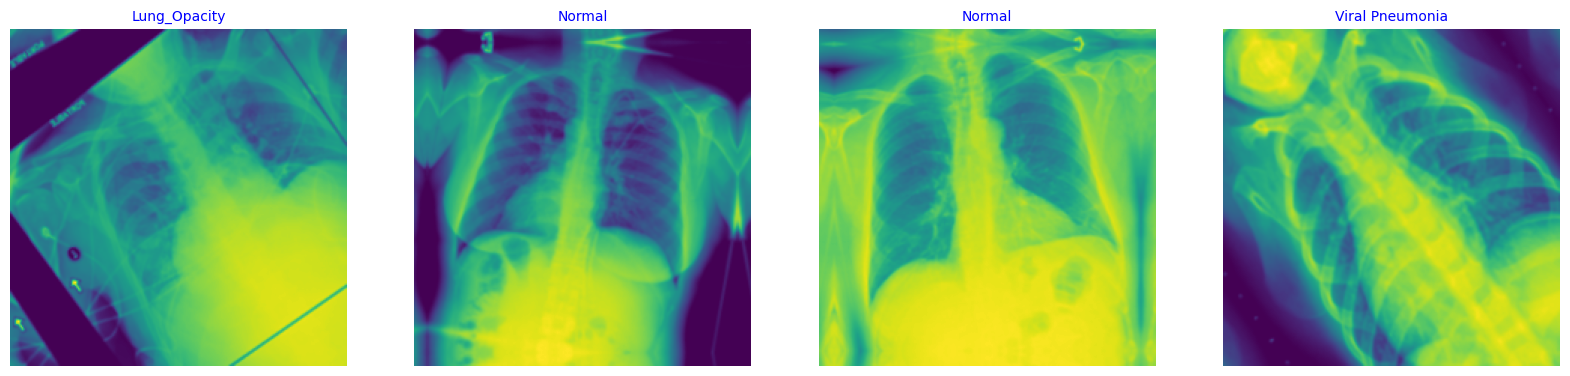

<BarContainer object of 4 artists>

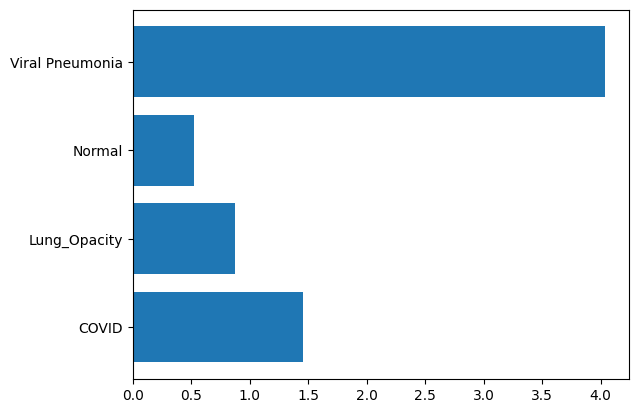

In [6]:
base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data', 'preprocessed')

# This can be used to test the data loading and generation
(ds_train, ds_valid, dsdd_test), class_weights_dict = generate_datasets(data_dir, case='raw', prep=True, target_shape=(224, 224, 3))    
# show some random images
show_sample_images(ds_train)

# Lets have a look at the class weights
plt.barh(ds_train.class_names, [weight for label, weight in class_weights_dict.items()])

### Loading and Training Model
Load and compile the model that has been defined in notebok 3b

In [ ]:
base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data', 'preprocessed')

# This loops can run over a given list of model names (have to exist in the structure of models/cnn/model_name/model_name.keras)
# and over several parameters like case ("raw", "roi"), prep (True, False) or target_shape

for model_name in ['VGG19']:
    for target_shape in [(224, 224, 3)]:
        for case in ['raw', 'roi']:
            for prep in [False, True]:
                
                # Load the datasets
                (ds_train, ds_valid, ds_test), class_weights_dict = generate_datasets(data_dir, case=case, prep=prep, target_shape=target_shape)
                ds_train.shuffle(123)
                ds_valid.shuffle(123)

                # Generate the specific run name
                model_fit = get_model_fit(case, prep)
                print('Training begins for {}'.format(model_name, model_fit))

                # Load the model that has been defined elsewhere
                model = load_model(
                    os.path.join(base_dir, 'models', 'cnn', model_name, model_name + '.keras')
                    )
                # model.summary()
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                
                # Set the callbacks including the timing logger
                timing_callback = TimingCallback()
                callbacks = [
                    ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.1, min_delta = 0.01, cooldown = 4, verbose = 1),
                    # EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=7),
                    timing_callback,
                    ]

                # Train the model
                history = model.fit(
                    ds_train, validation_data=ds_valid, callbacks=callbacks, class_weight=class_weights_dict,
                    epochs=25, initial_epoch=0
                )

                # Create the path for saving results
                model_path = os.path.join(base_dir, 'models', 'cnn', model_name, model_name + model_fit)

                # Save the training history and training duration
                logs = pd.DataFrame(timing_callback.logs | history.history).set_index('epoch')
                logs.to_csv(model_path + '_logs.csv')

                # Save the model with the trained parameters
                model.save(model_path + '.keras')

                # Predict and save the test dataset and decode the labels 
                pred_labels = tf.argmax(model.predict(ds_test), axis=-1).numpy()
                true_labels = tf.argmax(np.concatenate([y for x, y in ds_test], axis=0), axis=-1).numpy()
                pred_classes = [ds_train.class_names[i] for i in pred_labels]
                true_classes = [ds_train.class_names[i] for i in true_labels]
                result = pd.DataFrame({'true_labels': true_labels, 'pred_labels': pred_labels, 'true_classes': true_classes, 'pred_classes': pred_classes})
                result.to_csv(model_path + '_results.csv', index=False)
